<a href="https://colab.research.google.com/github/GANYMEDEBANK/3-1-PROJECT---Breast-Cancer/blob/main/HISTOLOGY2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazmulislam1803029","key":"b1c362bc793175237021a8fffe911213"}'}

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

In [ ]:
imagePatches = glob('/content/**/*.png', recursive=True)

In [ ]:
zeros = '*class0.png'
ones = '*class1.png'

class_zero = fnmatch.filter(imagePatches,zeros)
class_one = fnmatch.filter(imagePatches,ones)

In [ ]:
def process_img():
    x = []
    y = []
    H = 50
    W = 50
    for img in imagePatches[0:60000]:
        raw_image = cv2.imread(img)
        #inter_cubic(varriable) refers resulting image type in lower reg
        x.append(cv2.resize(raw_image, (W,H), interpolation=cv2.INTER_CUBIC))
        if img in class_zero:
            y.append(0)
        elif img in class_one:
            y.append(1)
        else:
            return
    return x,y

In [ ]:
X,Y = process_img()
df = pd.DataFrame()

In [ ]:
X = np.array(X)
X.shape


(60000, 50, 50, 3)

In [ ]:
Y = np.array(Y)
Y.shape

(60000,)

In [ ]:
# Make Data 1D for compatability upsampling methods
X_Shape = X.shape[1]*X.shape[2]*X.shape[3]
X_Flat = X.reshape(X.shape[0], X_Shape)


from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(sampling_strategy='auto')
X_Ros, Y_Ros = ros.fit_resample(X_Flat, Y)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
#Y_RosHot = to_categorical(Y_Ros, num_classes = 2)


for i in range(len(X_Ros)):
    height, width, channels = 50,50,3
    X_RosReshaped = X_Ros.reshape(len(X_Ros),height,width,channels)

X = np.array(X_RosReshaped)
Y = np.array(Y_Ros)

In [ ]:
Y.shape

(34060,)

In [ ]:
X.shape

(34060, 50, 50, 3)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


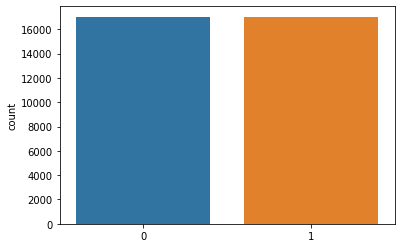

In [ ]:
sns.countplot(Y)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 0)

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test) 
Y_train = np.array(Y_train)
Y_test = np.array(Y_test) 

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20, 
        width_shift_range=0.2, 
        height_shift_range=0.2,  
        horizontal_flip=True,  
        vertical_flip=True) 

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3, 3),padding='same',  activation='relu',input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))


model.add(Dense(2,activation='softmax'))

In [ ]:
model.compile(optimizer = 'adam',
              loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'] )

In [ ]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=32), epochs = 20,
                    validation_data = (X_test, Y_test)
                    )

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


852/852 [==============================] - 156s 182ms/step - loss: 0.6137 - accuracy: 0.6777 - val_loss: 0.5808 - val_accuracy: 0.7208
Epoch 2/20
852/852 [==============================] - 157s 184ms/step - loss: 0.6246 - accuracy: 0.6685 - val_loss: 0.5341 - val_accuracy: 0.7556
Epoch 3/20
852/852 [==============================] - 152s 178ms/step - loss: 0.5652 - accuracy: 0.7379 - val_loss: 0.5808 - val_accuracy: 0.7452
Epoch 4/20
852/852 [==============================] - 150s 176ms/step - loss: 0.5474 - accuracy: 0.7504 - val_loss: 0.6070 - val_accuracy: 0.7039
Epoch 5/20
852/852 [==============================] - 149s 175ms/step - loss: 0.5417 - accuracy: 0.7529 - val_loss: 0.4941 - val_accuracy: 0.7930
Epoch 6/20
852/852 [==============================] - 149s 175ms/step - loss: 0.5566 - accuracy: 0.7431 - val_loss: 0.5582 - val_accuracy: 0.6881
Epoch 7/20
852/852 [==============================] - 148s 174ms/step - loss: 0.5427 - accuracy: 0.7504 - val_loss: 0.5051 - val_accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


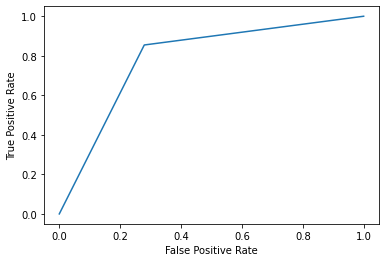

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      3359
           1       0.76      0.85      0.80      3453

    accuracy                           0.79      6812
   macro avg       0.79      0.79      0.79      6812
weighted avg       0.79      0.79      0.79      6812

213/213 - 8s - loss: 0.4899 - accuracy: 0.7886 - 8s/epoch - 35ms/step
0.7886083126068115


array([[2421,  938],
       [ 502, 2951]])

In [ ]:
Y_pred = model.predict_generator(X_test)
Y_pred = np.argmax(Y_pred, axis = 1)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
confusion_matrix(Y_test,Y_pred)
fpr, tpr, _ = roc_curve(Y_test, Y_pred)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show() 
print(classification_report(Y_test, Y_pred))
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose = 2)
print(test_acc)
confusion_matrix(Y_test,Y_pred)


In [ ]:
sample_path = "/content/9323/1/9323_idx5_x1001_y1501_class1.png"
test = []
raw_image = cv2.imread(sample_path)
#inter_cubic(varriable) refers resulting image type in lower reg
test.append(cv2.resize(raw_image, (50,50), interpolation=cv2.INTER_CUBIC))

test = np.array(test)


prediction = model.predict_generator(test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:

predd = np.argmax(prediction, axis = 1)

In [ ]:
if(predd[0] == 1):
    print("Invasive Ductal Carcinoma")
else:
    print(" Non Invasive Ductal Carcinoma")

Invasive Ductal Carcinoma


In [ ]:
print('agh')